In [11]:
import datetime
import random
import tracemalloc

import matplotlib.pyplot as plt
import numpy as np

INITIAL_LR = 1e-2

cnt = [0]

def get_eps(dim):
    return np.ones(dim) * 1e-7


def quadratic_grad(x, w, y, n):
    # print("x", x)
    # print("y", y)
    # print("w", w)
    # print("grad", ((x.dot(w) - y).dot(x)) / n)
    cnt[0] += 1 + n * (2 * n + n + 5) + 1
    return ((x.dot(w) - y).dot(x)) / n


def quadratic_grad_l1(x, w, y, n):
    cnt[0] += 1 + n * (2 * n + n + 5) + 1 + 2 * n
    return ((x.dot(w) - y).dot(x)) / n + np.sum(w / np.abs(w))


def quadratic_grad_l2(x, w, y, n):
    cnt[0] += 1 + n * (2 * n + n + 5) + 1 + n
    return ((x.dot(w) - y).dot(x)) / n + np.sum(w)


def quadratic_grad_elastic(x, w, y, n, lambd1=0.5, lambd2=0.9):
    cnt[0] += 1 + n * (2 * n + n + 5) + 1 + 3 * n
    return ((x.dot(w) - y).dot(x)) / n + lambd2*np.sum(w) + lambd1*np.sum(w / np.abs(w))


class StochasticGradDescCommon:
    dimensions, current, v, result, points, batch_size, gamma, learning_rate, iteration = [None] * 9

    def init(self, X_data, y_data, batch_size, gamma, learning_rate):
        self.dimensions = X_data.shape[1]
        self.current = np.zeros(self.dimensions)
        self.result = self.current
        self.points = list(zip(X_data, y_data))
        self.batch_size = batch_size
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.custom_init()

    def custom_init(self):
        pass

    def update(self, batch_x, batch_y):
        pass

    def get_batches(self, points):
        random.shuffle(points)
        batch_points = points[:self.batch_size]
        batch_x = np.array(list(map(lambda x: x[0], batch_points)))
        batch_y = np.array(list(map(lambda x: x[1], batch_points)))
        return batch_x, batch_y

    def get_error(self, batch_x, batch_y):
        # print("batch_x", batch_x)
        # print("current", self.current)
        # print("*", batch_x.dot(self.current))
        cnt[0] += 4 * len(batch_x)
        return np.sum(np.absolute(batch_x.dot(self.current) - batch_y)) / len(batch_x)

    def get_min(self, X_data, y_data, lr_schedule, learning_rate=INITIAL_LR, gamma=0.8,
                eps=1e-4, batch_size=1, max_iter=1000):
        self.init(X_data, y_data, batch_size, gamma, learning_rate)
        self.v = np.zeros(self.dimensions)
        for i in range(max_iter):
            self.iteration = i
            batch_x, batch_y = self.get_batches(self.points)
            error = self.get_error(batch_x, batch_y)
            if error < eps:
                return self.result
            self.update(batch_x, batch_y)
            self.result = np.vstack((self.result, self.current))
            learning_rate = lr_schedule(learning_rate, i)
        return self.result


class StochasticGradDesc(StochasticGradDescCommon):
    def update(self, batch_x, batch_y):
        cnt[0] += 2
        grad = quadratic_grad(batch_x, self.current, batch_y, self.dimensions)
        self.current -= self.learning_rate * grad


class NesterovStochasticDesc(StochasticGradDescCommon):
    def custom_init(self):
        self.v = np.zeros(self.dimensions)

    def update(self, batch_x, batch_y):
        cnt[0] += 5
        self.v = self.v * self.gamma + (1 - self.gamma) \
                 * quadratic_grad(batch_x, 
                                  self.current - self.learning_rate * self.gamma * self.v, 
                                  batch_y,
                                  self.dimensions)
        self.current -= self.learning_rate * self.v


class AdaGradStochasticDesc(StochasticGradDescCommon):
    g = None

    def custom_init(self):
        self.g = np.zeros((self.dimensions, self.dimensions))
        self.learning_rate *= 500

    def update(self, batch_x, batch_y):
        cnt[0] += len(batch_x) ** 2 + 2 * len(batch_x) + 4
        grad = quadratic_grad(batch_x, self.current, batch_y, self.dimensions)
        self.g += np.outer(grad, grad)
        diag = np.sqrt(self.g.diagonal())
        self.current -= self.learning_rate * grad / (diag + get_eps(self.dimensions))


class RMSStochasticDesc(StochasticGradDescCommon):
    beta = 0.8
    s = None

    def custom_init(self):
        self.beta = 0.98
        self.s = np.zeros(self.dimensions)

    def update(self, batch_x, batch_y):
        cnt[0] += len(batch_x) ** 2 + len(batch_x) + 4
        grad = quadratic_grad(batch_x, self.current, batch_y, self.dimensions)
        self.s = self.beta * self.s + (1 - self.beta) * grad * grad
        self.current -= 1 * grad / np.sqrt(self.s + get_eps(self.dimensions))


class AdamStochasticDesc(StochasticGradDescCommon):
    beta_one, beta_two, s = [None] * 3

    def custom_init(self):
        self.beta_one = 0.9
        self.beta_two = 0.8
        self.v = np.zeros(self.dimensions)
        self.s = np.zeros(self.dimensions)

    def get_grad(self, batch_x, batch_y):
        return quadratic_grad(batch_x, self.current, batch_y, self.dimensions)

    def update(self, batch_x, batch_y):
        p = len(batch_x)
        cnt[0] += p * p + p + 10
        grad = quadratic_grad(batch_x, self.current, batch_y, self.dimensions)
        self.v = self.beta_one * self.v + (1 - self.beta_one) * grad
        self.s = self.beta_two * self.s + (1 - self.beta_two) * grad * grad
        v_inv = self.v / (1 - self.beta_one ** self.iteration + get_eps(self.dimensions))
        s_inv = self.s / (1 - self.beta_two ** self.iteration + get_eps(self.dimensions))
        self.current -= 0.1 * v_inv / np.sqrt(s_inv + get_eps(self.dimensions))


class AdamWithL1(AdamStochasticDesc):
    def get_grad(self, batch_x, batch_y):
        return quadratic_grad_l1(batch_x, self.current, batch_y, self.dimensions)


class AdamWithL2(AdamStochasticDesc):
    def get_grad(self, batch_x, batch_y):
        return quadratic_grad_l2(batch_x, self.current, batch_y, self.dimensions)


class AdamWithElasticNet(AdamStochasticDesc):
    def get_grad(self, batch_x, batch_y):
        return quadratic_grad_elastic(batch_x, self.current, batch_y, self.dimensions)


def const_lr(learning_rate, iter_num):
    return learning_rate


def step_lr(learning_rate,
            iter_num,
            initial_lr=INITIAL_LR,
            drop=1.2,
            frequency=10):
    return initial_lr * np.power(drop, np.floor((iter_num + 1) / frequency))


def exponential_lr(learning_rate,
                   iter_num,
                   initial_lr=INITIAL_LR,
                   k=1e-2):
    return initial_lr * np.exp(-k * iter_num)


def f(x):
    return 0.13 * x[0] + 4.41 * x[1]

data_size = 10
X = np.empty((data_size, 2))
y = np.empty((data_size))
for i in range(data_size):
    x = np.random.uniform(-3, 3, 2)
    X[i] = x
    y[i] = f(x) #+ np.random.rand()


def test(grad_desc, lr_scheduler, x, y):
    print()
    for batch_size in range(1, len(y) + 1):
        cnt[0] = 0
        tracemalloc.start()
        start = datetime.datetime.utcnow()
        result = grad_desc(x, y, lr_scheduler, batch_size=batch_size)
        comp_time = (datetime.datetime.utcnow() - start).total_seconds()
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        values = result[-1]
        print(values)
        print(f'iterations: {len(result)}, batch_size: {batch_size}, computing_time: {comp_time}s, arithmetic operations: {cnt[0]}, peak was {peak / 10**6}MB')


def polynomial_regression(real_c, points_amount=20):
    x_points = []
    y_points = []
    xses = []
    dim = real_c.shape[0]
    for i in range(points_amount):
        x_value = float((np.random.rand(1) - 0.5) * 4)
        x_points_value = np.array([np.power(x_value, i) for i in range(dim)])
        y_value = real_c.dot(x_points_value)
        x_points.append(x_points_value)
        y_points.append(y_value)
        xses.append(x_value)
    x_points = np.array(x_points)
    y_points = np.array(y_points)
    y_points += np.random.normal(0, 0.5, points_amount)
    result = AdamWithElasticNet().get_min(x_points, y_points, exponential_lr, batch_size=points_amount // 10)
    print(real_c, result[-1], len(result))
    return result[-1], (xses, y_points)


[0.12935892 4.40926605]
iterations: 853, batch_size: 1, computing_time: 0.053242s, arithmetic operations: 25564, peak was 0.182458MB
[0.12984973 4.40987628]
iterations: 480, batch_size: 2, computing_time: 0.027869s, arithmetic operations: 16294, peak was 0.018331MB
[0.12989202 4.40992584]
iterations: 320, batch_size: 3, computing_time: 0.020403s, arithmetic operations: 12134, peak was 0.012584MB
[0.12993522 4.40995666]
iterations: 250, batch_size: 4, computing_time: 0.016277s, arithmetic operations: 10474, peak was 0.010268MB
[0.12993896 4.40995829]
iterations: 206, batch_size: 5, computing_time: 0.012301s, arithmetic operations: 9450, peak was 0.00886MB
[0.1299395  4.40995201]
iterations: 170, batch_size: 6, computing_time: 0.010185s, arithmetic operations: 8474, peak was 0.007756MB
[0.12993997 4.40995066]
iterations: 142, batch_size: 7, computing_time: 0.01117s, arithmetic operations: 7642, peak was 0.006812MB
[0.12994071 4.4099518 ]
iterations: 122, batch_size: 8, computing_time: 0

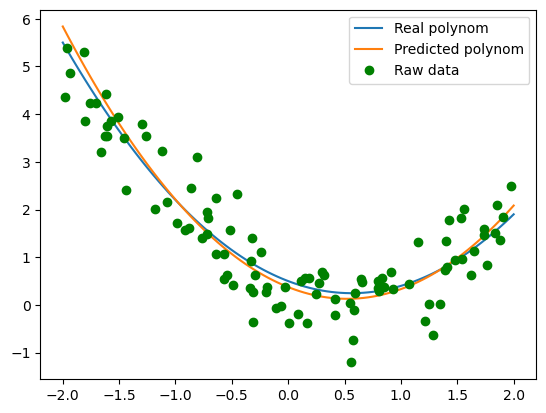

In [12]:
# constant learning rate
test(StochasticGradDesc().get_min, const_lr, X, y)

# exponential learning rate
test(StochasticGradDesc().get_min, exponential_lr, X, y)

# Nesterov optimisation
test(NesterovStochasticDesc().get_min, exponential_lr, X, y)

# AdaGrad optimisation
test(AdaGradStochasticDesc().get_min, const_lr, X, y)

# RMSProp optimisation
test(RMSStochasticDesc().get_min, exponential_lr, X, y)

# Adam optimisation
test(AdamStochasticDesc().get_min, exponential_lr, X, y)

# Polynomial regression
print()
coeffs = np.array([0.5, -0.9, 0.8])
data = polynomial_regression(coeffs, 100)
predicted_coeffs = data[0]
points = data[1]

coeffs = np.flip(coeffs)
predicted_coeffs = np.flip(predicted_coeffs)
x = np.linspace(-2, 2, 100)
y1 = [np.polyval(coeffs, i) for i in x]
y2 = [np.polyval(predicted_coeffs, i) for i in x]
plt.plot(x, y1, label='Real polynom')
plt.plot(x, y2, label='Predicted polynom')
plt.plot(points[0], points[1], 'go', label='Raw data')
plt.legend()
plt.show()


In [81]:
def test2(grad_desc, lr_scheduler, x, y):
    print()
    for batch_size in range(3, 4):
        start = datetime.datetime.utcnow()
        result = grad_desc(x, y, lr_scheduler, batch_size=batch_size)
        comp_time = (datetime.datetime.utcnow() - start).total_seconds()
        values = result[-1]
        print(values)
        print(f'iterations: {len(result)}, batch_size: {batch_size}, computing_time: {comp_time}s')

In [75]:
test2(StochasticGradDesc().get_min, const_lr, X, y)


[0.1300483 4.4098725]
iterations: 283, batch_size: 3, computing_time: 0.045501s
